In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import TeledyneCMOS, TCMOS_no_spatial
from pyeosim.postprocess import CmosReflectance
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

In [251]:
cmos = TCMOS_no_spatial(TDI_rows=32,
                        store_steps=False,
                        ground_sample_distance=2)

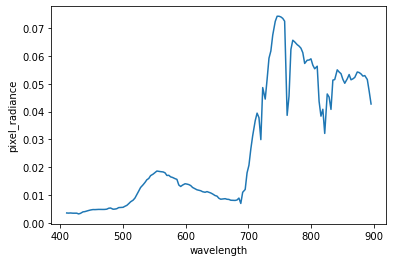

In [252]:
TOA_bands = cmos.spectral_response.transform(TOA)
TOA_ndvi = (TOA_bands.isel(band=9) - TOA_bands.isel(band=5))/(TOA_bands.isel(band=9) + TOA_bands.isel(band=5))
TOA_veg_median = TOA.where(TOA_ndvi > 0).median(['x','y'])
TOA_veg_median.plot()

In [253]:
# Use the vegetation median signal to generate as a percentage (1% - 200%)
_ar = np.atleast_2d(np.linspace(.01,2,200)).T * TOA_veg_median.values
test_array = xarray.DataArray(
    np.broadcast_to(np.atleast_3d(_ar), (200, 153, 300)),
    coords=[('x', np.arange(200)),
             ('wavelength', TOA.wavelength),
             ('y', np.arange(300))]).transpose('y', 'x',...)

band_radiances = cmos.spectral_response.transform(test_array) * 1000  # in microns-1

In [254]:
test_output = cmos.fit_transform(test_array)
test_output = test_output.assign_coords(TOA_radiance=(['band','x'],
                                                      band_radiances.isel(y=0).values))
test_output = test_output.swap_dims({'band':'band_name'})
SNR = test_output.mean('y')/test_output.std('y')
median_vegetation_SNR = SNR.isel(x=100).to_pandas()
median_vegetation_SNR

band_name
Clouds           18.664776
Carotenoids      25.961442
PRI_1            21.278915
PRI_2            35.412279
Chlorophyll_1    28.657957
Chlorophyll_2    31.956059
RedEdge_1        33.599289
RedEdge_2        61.590616
RedEdge_3        61.777214
NIR              79.987738
dtype: float64

/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='band_name'>

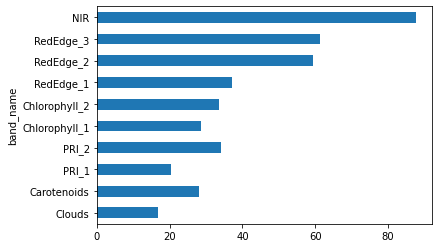

In [246]:
median_vegetation_SNR.plot('barh')

Text(456.8823529411765, 0.5, 'SNR')

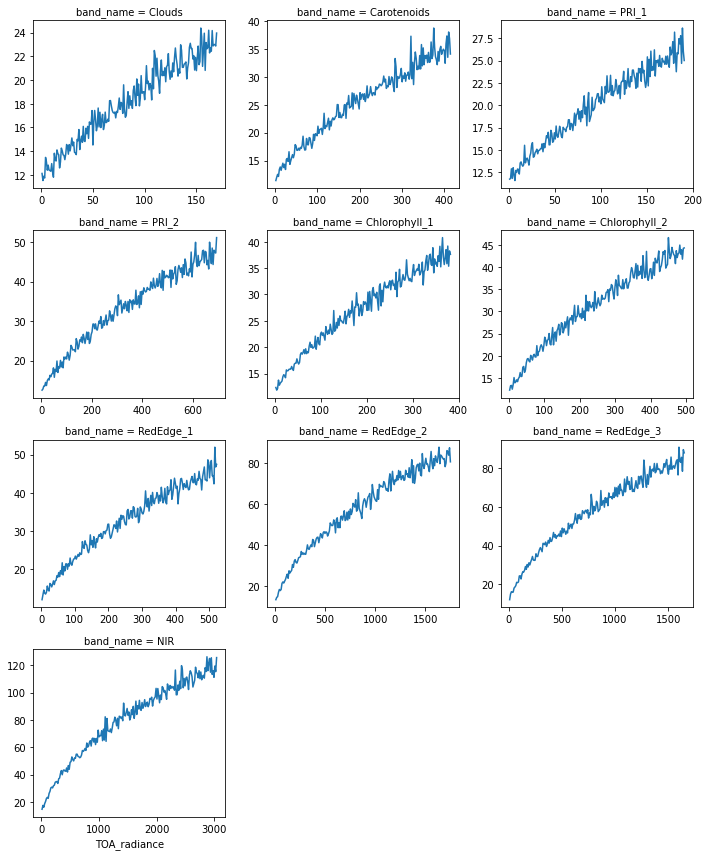

In [256]:
SNR.plot(x='TOA_radiance', col='band_name',sharex=False, sharey=False, col_wrap=3)
plt.xlabel('TOA radiance (W m-2 sr-1 micron-1)')
plt.ylabel('SNR')